In [1]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip3 install peewee pytorch-lightning

# # not sure if tensorboardx is needed
# !pip3 install peewee pytorch-lightning tensorboard tensorboardx

# !pip3 install chess

# # performance profiling
# !pip install scalene


In [2]:
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [3]:
# !wget https://storage.googleapis.com/chesspic/datasets/2021-07-31-lichess-evaluations-37MM.db.gz
# !gzip -d "2021-07-31-lichess-evaluations-37MM.db.gz"
# !rm "2021-07-31-lichess-evaluations-37MM.db.gz"

In [160]:
from peewee import Model as ORMModel, IntegerField, TextField, BlobField, FloatField, SqliteDatabase
import base64

db = SqliteDatabase('./test.db')

def fen_as_input(fen: str):
    import numpy as np
    import chess
    board = chess.Board(fen)
    inputs = np.zeros(65, dtype=np.float16)
    for i in range(64):
        piece = board.piece_at(i)
        if piece is not None:
            inputs[i] = piece.piece_type * (1 if piece.color == chess.WHITE else -1)
    inputs[64] = 1 if board.turn == chess.WHITE else -1 # forgor this earlier ☠
    return inputs

class Evaluations(ORMModel):
    id = IntegerField()
    fen = TextField()
    binary = BlobField()
    eval = FloatField()

    class Meta:
        database = db

    def binary_base64(self):
        return base64.b64encode(self.binary)
    
    def as_input(self):
        return fen_as_input(self.fen)
    
    def display(self):
        from IPython.display import display, SVG
        SVG_BASE_URL = "https://us-central1-spearsx.cloudfunctions.net/chesspic-fen-image/"
        fen_board = self.fen.split()[0]
        display(SVG(url=SVG_BASE_URL + fen_board))

db.connect()

True

In [5]:
LABEL_COUNT = Evaluations.select().count()
print(LABEL_COUNT)

37164639


rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq d3 0 1
b'CAAAAAAAAAAQAAAAAAAAAIEAAAAAAAAAJAAAAAAAAABCAAAAAAAAAADvABAAAAAAAAAAAAAAAAgAAAAAAAAAEAAAAAAAAACBAAAAAAAAACQAAAAAAAAAQgAAAAAAAP8AAAABEz8='
[ 4.  2.  3.  5.  6.  3.  2.  4.  1.  1.  1.  0.  1.  1.  1.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1. -1. -1. -1.
 -1. -1. -4. -2. -3. -5. -6. -3. -2. -4. -1.]


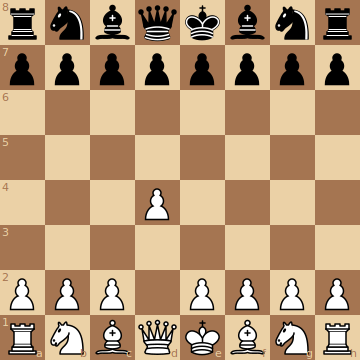

In [6]:
eval = Evaluations.get(Evaluations.id == 1)
print(eval.fen)
print(eval.binary_base64())
print(eval.as_input())
eval.display()

In [7]:
import os
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset, random_split
import pytorch_lightning as pl
from random import randrange

class EvaluationDataset(IterableDataset):
  def __init__(self, count):
    self.count = count
  def __iter__(self):
    return self
  def __next__(self):
    idx = randrange(self.count)
    return self[idx]
  def __len__(self):
    return self.count
  def __getitem__(self, idx):
    eval = Evaluations.get(Evaluations.id == idx+1)
    # bin = np.frombuffer(eval.binary, dtype=np.uint8)
    # bin = np.unpackbits(bin, axis=0).astype(np.single)
    eval.eval = max(eval.eval, -15)
    eval.eval = min(eval.eval, 15)
    ev = np.array([eval.eval]).astype(np.single)
    input = eval.as_input()
    return {'input': input, 'eval':ev}

dataset = EvaluationDataset(count=LABEL_COUNT)

c:\Users\TeamD\.conda\envs\chess2\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


# Dataset profiling

In [8]:
# import timeit
# start = timeit.default_timer()
# for i in range(10_000):
#     dataset[randrange(LABEL_COUNT)]
# stop = timeit.default_timer()
# print('Time: ', stop - start)

In [9]:
# %%scalene
# rtn = Evaluations.select().limit(10_000).select()
# print(rtn)
# print(len(rtn))
# inputs = [eval.as_input() for eval in rtn]

# Training

In [10]:
torch.set_float32_matmul_precision('medium')

In [11]:

import time
from collections import OrderedDict
class EvaluationModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, batch_size=1024):
        super().__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # Define the layer sizes
        layer_sizes = [65, 32, 30, 21, 1]
        
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append((f"linear-{i}", nn.Linear(layer_sizes[i], layer_sizes[i + 1])))
            
            # We don't want ReLU activation after the last linear layer
            if i != len(layer_sizes) - 2:
                layers.append((f"relu-{i}", nn.ReLU()))
                
        self.seq = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        return self.seq(x)

    def training_step(self, batch, batch_idx):
        x, y = batch['input'], batch['eval']
        y_hat = self(x)
        loss = F.l1_loss(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def train_dataloader(self):
        dataset = EvaluationDataset(count=LABEL_COUNT)
        # return DataLoader(dataset, batch_size=self.batch_size, num_workers=0, pin_memory=True)
        return DataLoader(dataset, batch_size=self.batch_size, num_workers=12, pin_memory=True)

In [12]:
# batch_size=512
batch_size=10_000
batch_size=50_000
version_name = f'{int(time.time())}-batch_size-{batch_size}'
logger = pl.loggers.TensorBoardLogger("lightning_logs", name="chessml", version=version_name)


In [13]:
# Start tensorboard.
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 14944), started 3 days, 1:24:18 ago. (Use '!kill 14944' to kill it.)

In [14]:
# trainer = pl.Trainer(accelerator="gpu", devices=-1, precision=16, max_epochs=1, logger=logger)
trainer = pl.Trainer(accelerator="gpu", devices=-1, precision="16-mixed", max_epochs=1, logger=logger)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
model = EvaluationModel(batch_size=batch_size, learning_rate=1e-3).to("cuda")

In [16]:
from glob import glob

found = glob("model*.pt")
print(found)
# make form field for jupyter
load = found[-1]

['model1-noturn-1690155046.pt', 'model2-withturn-1690159539.pt', 'model2-withturn-1690160543.pt']


In [17]:
model.load_state_dict(torch.load(load))

<All keys matched successfully>

In [221]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | seq  | Sequential | 3.8 K 
------------------------------------
3.8 K     Trainable params
0         Non-trainable params
3.8 K     Total params
0.015     Total estimated model params size (MB)


Epoch 0:  10%|█         | 75/744 [34:56<5:11:36, 27.95s/it, v_num=0000]

In [222]:
torch.save(model.state_dict(), f"model2-withturn-{int(time.time())}.pt")

# Test it

In [153]:
import random
eval = Evaluations.get(Evaluations.id == random.randint(1, LABEL_COUNT))
print(eval)
x = eval.as_input()
print(x)
y = model(torch.from_numpy(x).float().cuda())
print(y)
print("expected: ", eval.eval)

33750355
[ 0.  0.  6.  4.  0.  0.  0.  0.  0.  1.  1.  2.  0.  1.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  1.  0.  1.  0.  0.  0. -2.  2.
 -1.  0.  0.  4.  0.  0.  0. -1. -3.  0.  0.  0. -1. -1.  0.  0.  0. -2.
  0. -1. -4.  0.  0. -5.  0. -4. -6.  0. -1.]
tensor([-0.4485], device='cuda:0', grad_fn=<AddBackward0>)
expected:  -9.96


PovScore(Cp(-31), BLACK)
tensor([0.2356], device='cuda:0', grad_fn=<AddBackward0>)


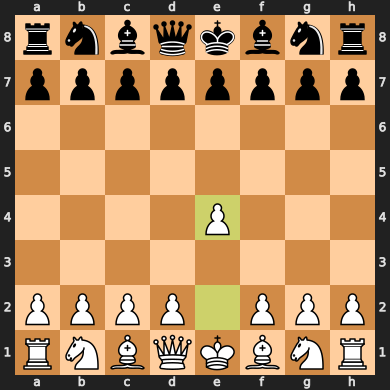

In [194]:
import chess
import chess.engine

board = chess.Board(chess.STARTING_BOARD_FEN)
board.push_san("e4")

engine = chess.engine.SimpleEngine.popen_uci(r"..\..\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2.exe")
info = engine.analyse(board, chess.engine.Limit(time=2.0))
print(info["score"])

print(model(torch.from_numpy(fen_as_input(board.fen())).float().cuda()))
board

In [217]:
expected.pov(not board.turn)

Cp(-87)

<LegalMoveGenerator at 0x21537eb0d90 (Nh3, Nf3, Ne2, Ba6, Bb5, Bc4, Bd3, Be2, Ke2, Qh5, Qg4, Qf3, Qe2, Nc3, Na3, e5, h3, g3, f3, d3, c3, b3, a3, h4, g4, f4, d4, c4, b4, a4)>
move g1h3
expected -150
actual tensor([-0.6596], device='cuda:0', grad_fn=<AddBackward0>)


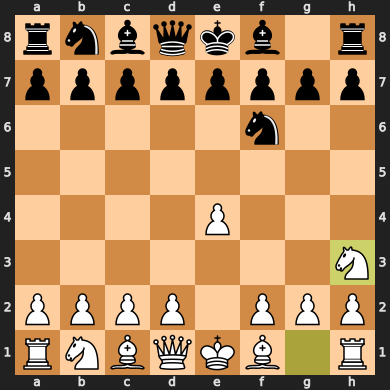

move g1f3
expected -86
actual tensor([-0.4382], device='cuda:0', grad_fn=<AddBackward0>)


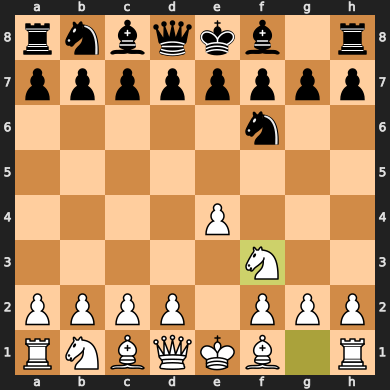

move g1e2
expected -129
actual tensor([-0.6179], device='cuda:0', grad_fn=<AddBackward0>)


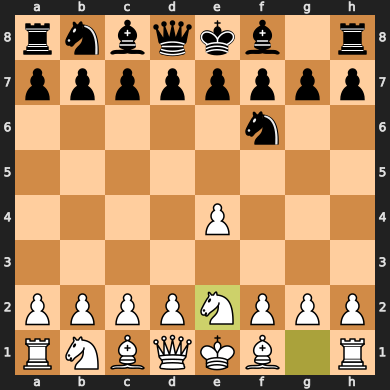

move f1a6
expected -498
actual tensor([-0.4858], device='cuda:0', grad_fn=<AddBackward0>)


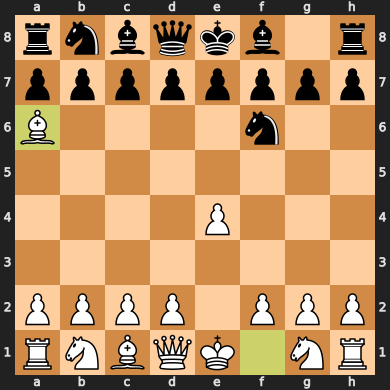

move f1b5
expected -134
actual tensor([-0.1747], device='cuda:0', grad_fn=<AddBackward0>)


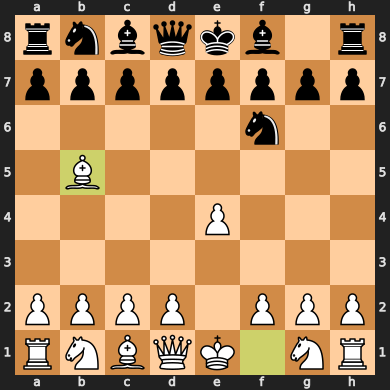

move f1c4
expected -139
actual tensor([-0.0297], device='cuda:0', grad_fn=<AddBackward0>)


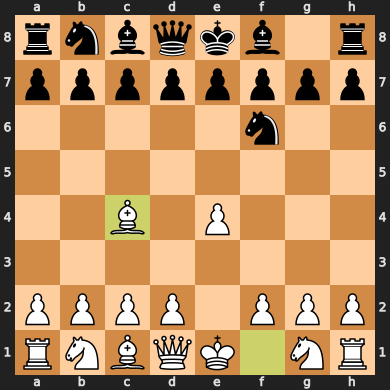

move f1d3
expected -15
actual tensor([0.0564], device='cuda:0', grad_fn=<AddBackward0>)


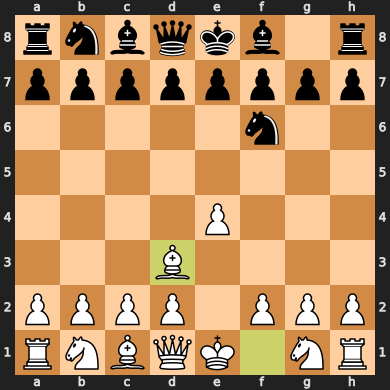

move f1e2
expected -116
actual tensor([-0.1777], device='cuda:0', grad_fn=<AddBackward0>)


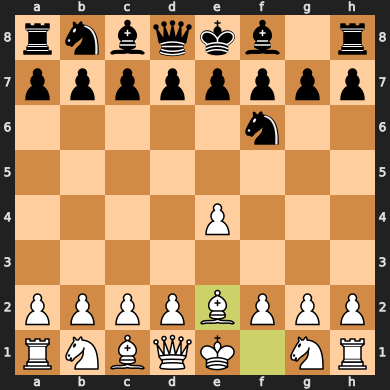

move e1e2
expected -193
actual tensor([-0.1707], device='cuda:0', grad_fn=<AddBackward0>)


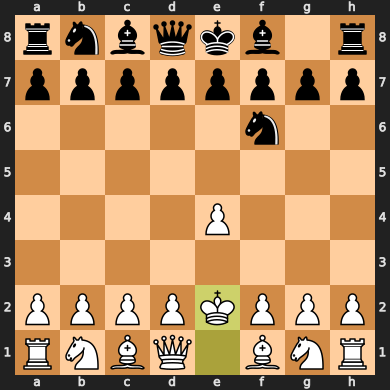

move d1h5
expected -733
actual tensor([0.2321], device='cuda:0', grad_fn=<AddBackward0>)


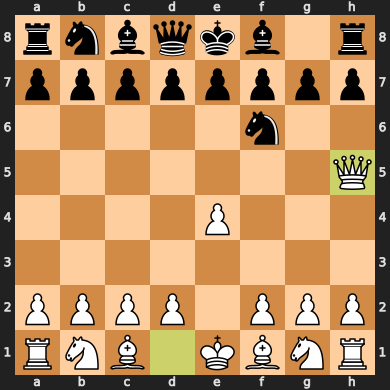

move d1g4
expected -738
actual tensor([-0.3852], device='cuda:0', grad_fn=<AddBackward0>)


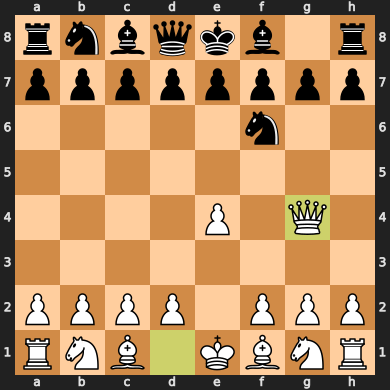

move d1f3
expected -42
actual tensor([0.0812], device='cuda:0', grad_fn=<AddBackward0>)


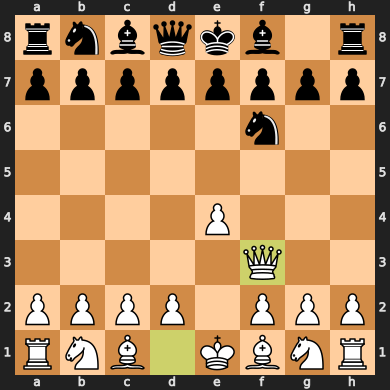

move d1e2
expected -31
actual tensor([-0.4734], device='cuda:0', grad_fn=<AddBackward0>)


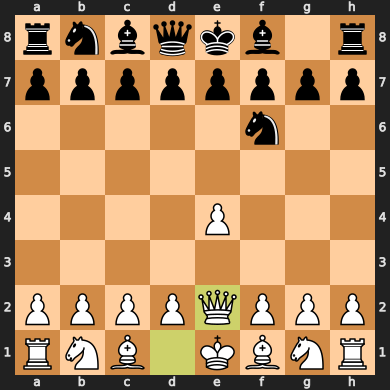

move b1c3
expected 19
actual tensor([0.0017], device='cuda:0', grad_fn=<AddBackward0>)


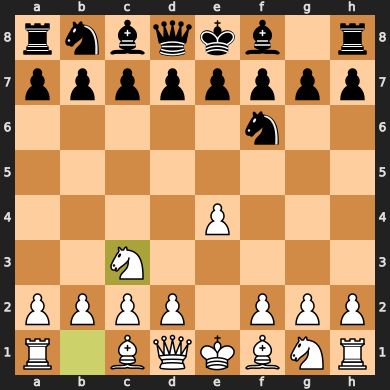

move b1a3
expected -157
actual tensor([-0.4056], device='cuda:0', grad_fn=<AddBackward0>)


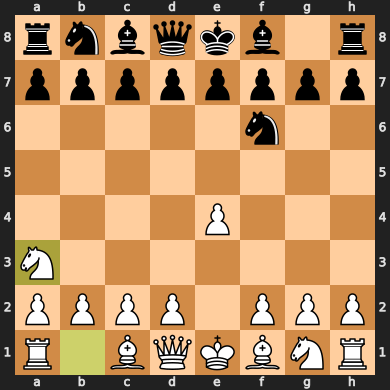

move e4e5
expected 85
actual tensor([-0.4662], device='cuda:0', grad_fn=<AddBackward0>)


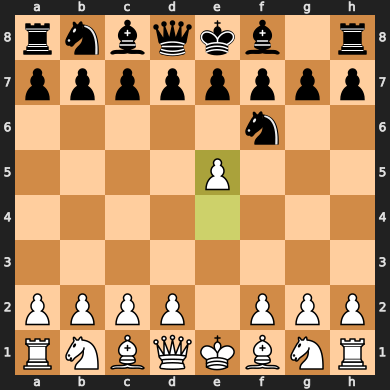

move h2h3
expected -127
actual tensor([-0.5604], device='cuda:0', grad_fn=<AddBackward0>)


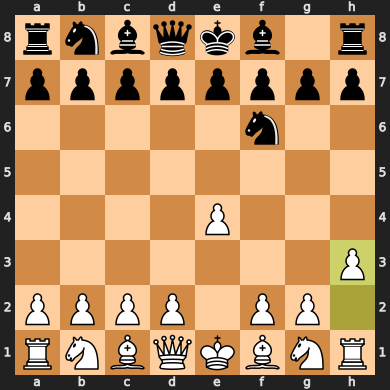

move g2g3
expected -133
actual tensor([-0.4700], device='cuda:0', grad_fn=<AddBackward0>)


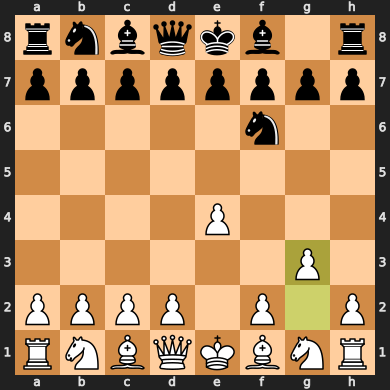

move f2f3
expected -25
actual tensor([-0.4488], device='cuda:0', grad_fn=<AddBackward0>)


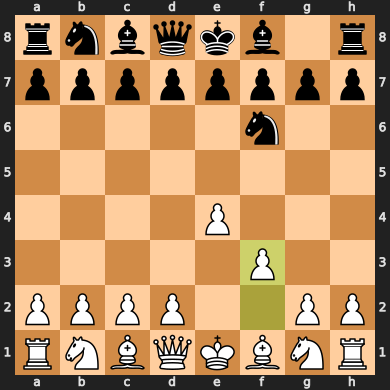

move d2d3
expected 0
actual tensor([-0.4142], device='cuda:0', grad_fn=<AddBackward0>)


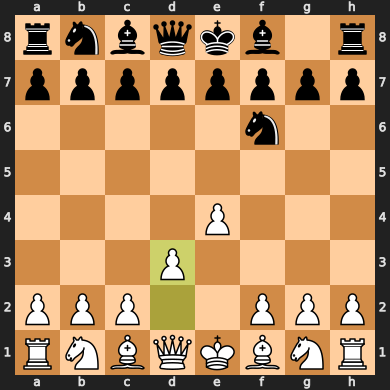

move c2c3
expected -119
actual tensor([-0.4130], device='cuda:0', grad_fn=<AddBackward0>)


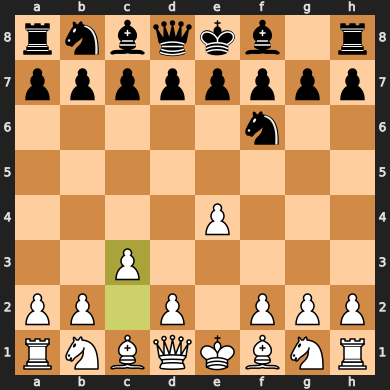

move b2b3
expected -133
actual tensor([-0.4705], device='cuda:0', grad_fn=<AddBackward0>)


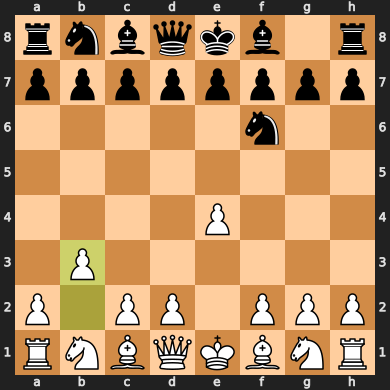

move a2a3
expected -115
actual tensor([-0.4748], device='cuda:0', grad_fn=<AddBackward0>)


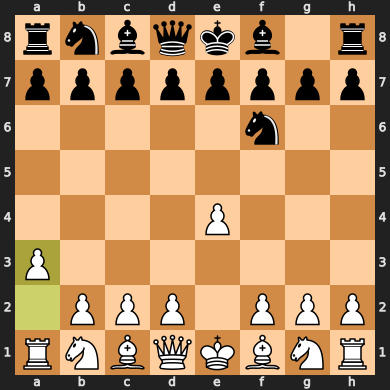

move h2h4
expected -121
actual tensor([-0.5028], device='cuda:0', grad_fn=<AddBackward0>)


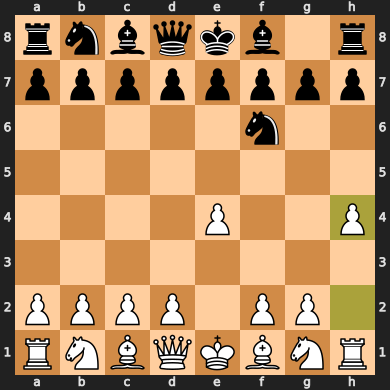

move g2g4
expected -117
actual tensor([-0.5532], device='cuda:0', grad_fn=<AddBackward0>)


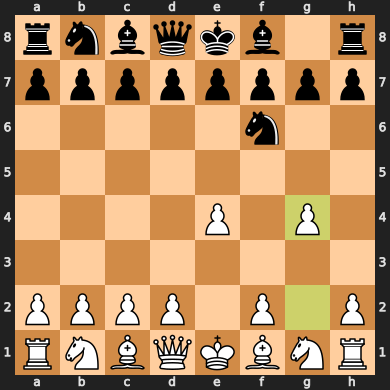

move f2f4
expected -125
actual tensor([-0.5003], device='cuda:0', grad_fn=<AddBackward0>)


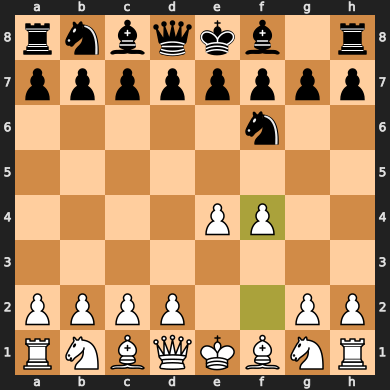

move d2d4
expected -72
actual tensor([-0.3508], device='cuda:0', grad_fn=<AddBackward0>)


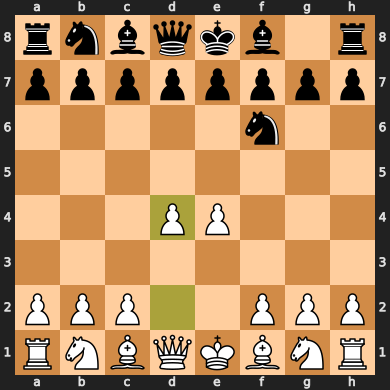

move c2c4
expected -91
actual tensor([-0.4652], device='cuda:0', grad_fn=<AddBackward0>)


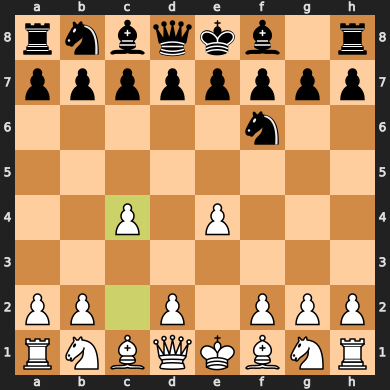

move b2b4
expected -153
actual tensor([-0.5044], device='cuda:0', grad_fn=<AddBackward0>)


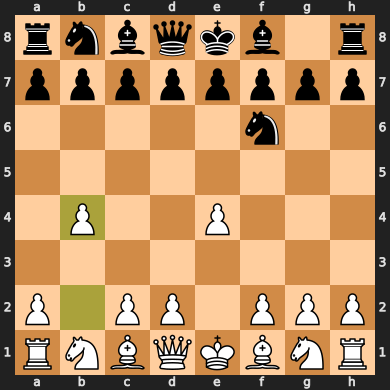

move a2a4
expected -130
actual tensor([-0.4162], device='cuda:0', grad_fn=<AddBackward0>)


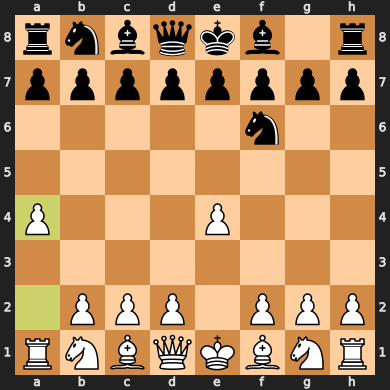

best expected e4e5 85


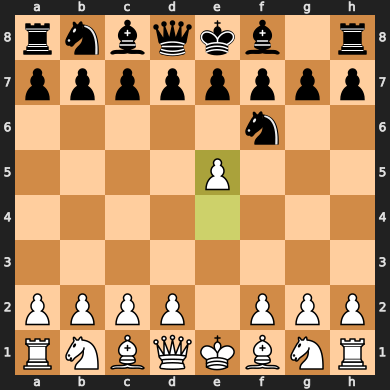

best actual d1h5 tensor([0.2321], device='cuda:0', grad_fn=<AddBackward0>)


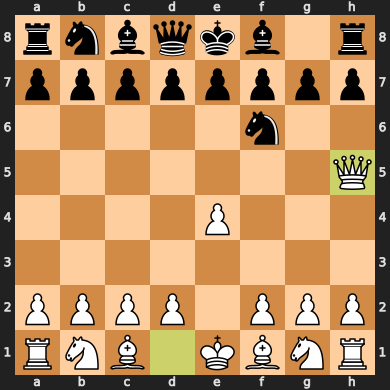

Move.from_uci('d1h5')

In [223]:
print(board.legal_moves)

best_expected_score = None
best_expected_move = None
best_actual_score = None
best_actual_move = None

for move in board.legal_moves:
    board.push(move)
    print("move", move)
    expected = engine.analyse(board, chess.engine.Limit(time=1.0))["score"].pov(not board.turn).score()
    print("expected", expected)
    actual = model(torch.from_numpy(fen_as_input(board.fen())).float().cuda())
    print("actual", actual)

    if best_expected_score is None or expected > best_expected_score:
        best_expected_score = expected
        best_expected_move = move

    if best_actual_score is None or actual > best_actual_score:
        best_actual_score = actual
        best_actual_move = move


    display(board)
    board.pop()

print("best expected", best_expected_move, best_expected_score)
board.push(best_expected_move)
display(board)
board.pop()

print("best actual", best_actual_move, best_actual_score)
board.push(best_actual_move)
display(board)
board.pop()

# TODO

- Normalize score to be predicted such that it is always within [-1, 1]
- Precompute input tensors for all games in db
- Separate evaluation notebooks
- Clean up git repo



Idx 27294511 Eval 2.83 Prediction 0.85 Loss 1.98
FEN r1bq1rk1/1p3pbp/p1pp2p1/2nPp2n/P1P1P3/2N2N1P/1PB2PP1/R1BQ1RK1 w - - 3 12


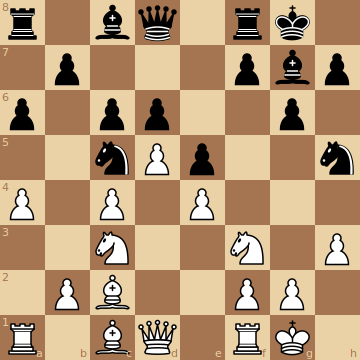

Idx 6239994 Eval -0.38 Prediction -3.08 Loss 2.70
FEN r4rk1/1pp3pp/p4p2/1b1pq3/4pN2/1P2P1PP/P1PP2P1/R2QK2R w KQ - 0 18


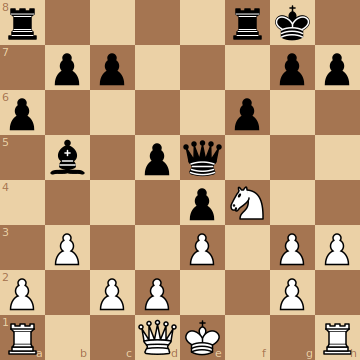

Idx 12770557 Eval -5.55 Prediction -6.25 Loss 0.70
FEN r2qk1nr/ppp2ppp/4p3/8/2PP1N2/4P3/PPbQ1PPP/n3KBNR b kq - 0 11


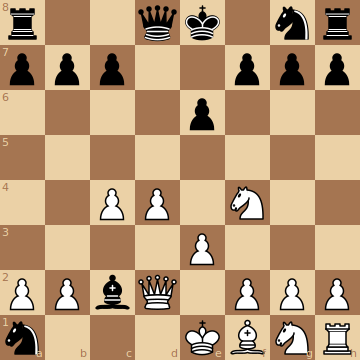

Idx 9958598 Eval -0.37 Prediction -4.16 Loss 3.79
FEN 5rk1/5pbp/p5b1/1p6/6P1/1B3NQ1/Pq1R1PK1/8 b - - 0 33


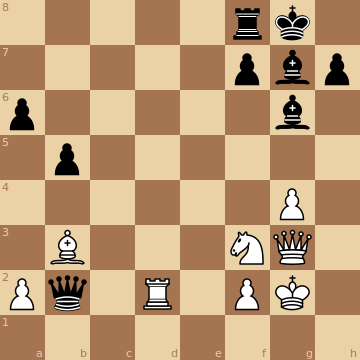

Idx 20264693 Eval 5.12 Prediction -0.97 Loss 6.09
FEN r3kbnr/ppp2ppp/4p1q1/3P4/1n1N4/P1N2P2/1P1Q2PP/R1B2K1R w kq - 0 13


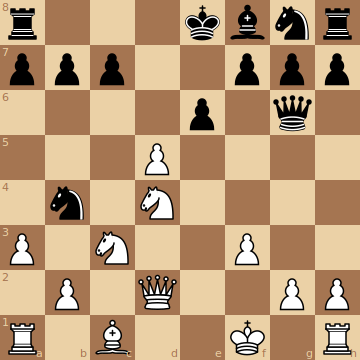

In [225]:
def show_index(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  batch = dataset[idx]
  x, y = torch.tensor(batch['input']).float().cuda(), torch.tensor(batch['eval']).cuda()
  y_hat = model(x)
  loss = F.l1_loss(y_hat, y)
  print(f'Idx {idx} Eval {y.data[0]:.2f} Prediction {y_hat.data[0]:.2f} Loss {loss:.2f}')
  print(f'FEN {eval.fen}')
  eval.display()

for i in range(5):
  idx = randrange(LABEL_COUNT)
  show_index(idx)

# Serialize it

In [42]:
for k,v in model.state_dict().items():
    print(k, v.shape)

seq.linear-0.weight torch.Size([32, 65])
seq.linear-0.bias torch.Size([32])
seq.linear-1.weight torch.Size([30, 32])
seq.linear-1.bias torch.Size([30])
seq.linear-2.weight torch.Size([21, 30])
seq.linear-2.bias torch.Size([21])
seq.linear-3.weight torch.Size([1, 21])
seq.linear-3.bias torch.Size([1])


In [43]:
model.state_dict()

OrderedDict([('seq.linear-0.weight',
              tensor([[ 0.1375,  0.0329,  0.0862,  ..., -0.0681, -0.0352,  0.0498],
                      [-0.0150, -0.0554,  0.0984,  ...,  0.0011, -0.0479,  0.0401],
                      [ 0.0504, -0.0381,  0.0804,  ...,  0.0768,  0.0335,  0.0644],
                      ...,
                      [-0.1096,  0.0746, -0.0652,  ...,  0.0468,  0.0754,  0.1190],
                      [ 0.1177,  0.0886,  0.0429,  ..., -0.0150,  0.0761, -0.0115],
                      [ 0.0902,  0.0303,  0.1309,  ...,  0.0595, -0.0170, -0.0707]],
                     device='cuda:0')),
             ('seq.linear-0.bias',
              tensor([-0.1080,  0.0426, -0.1452,  0.0972,  0.0558,  0.0335,  0.0741,  0.0421,
                      -0.0889,  0.0140, -0.0202,  0.0136, -0.0345,  0.0718, -0.0711,  0.0617,
                       0.0380, -0.0668,  0.0932, -0.0643,  0.1164,  0.1048,  0.0589,  0.1528,
                      -0.0177,  0.0187,  0.1427, -0.0669, -0.0912,  0.0224

In [48]:
def pack_weights_and_biases(model):
    # Create an empty list to store all weights and biases.
    weights_biases_list = []

    # Loop over all layers.
    for key, param in model.state_dict().items():
        # Convert tensor to numpy array, flatten it and convert to list.
        param_list = param.detach().cpu().numpy().flatten().tolist()
        weights_biases_list.extend(param_list)

    # Ensure all values are between -1 and 1.
    assert all(-1 <= val <= 1 for val in weights_biases_list), "All weights and biases should be between -1 and 1."

    # Convert the normalized values to the range [0, 255].
    weights_biases_list = [int((w + 1) / 2 * 255) for w in weights_biases_list]

    # Now pack every eight 8-bit values into a long.
    packed_weights_biases = []
    for i in range(0, len(weights_biases_list), 8):
        packed_long = 0
        for j in range(8):
            if i + j < len(weights_biases_list):
                packed_long |= weights_biases_list[i + j] << (j * 8)
        packed_weights_biases.append(packed_long)

    return packed_weights_biases

packed_weights = pack_weights_and_biases(model)
print(str(packed_weights)[1:-1])


9191159041496875921, 10052740862267658360, 8895593853055956351, 9906107814340165253, 9043947632920461442, 8901233252824676477, 8681411152511267977, 8896444918255486597, 8901504918011542917, 8613857274030163844, 9043640954942948228, 9329628340325874043, 9835997330791952763, 10051058614072867956, 9112880487843201645, 9183838523041484655, 9544945693584884857, 9905816387942318450, 8466908571509621375, 9263493776687988597, 8754844291428741773, 9407607822537166203, 9042251159242771085, 10267216002925299326, 10053310297839993737, 10482268374049783161, 8326738392432540540, 7889605559190064519, 7957157363268024439, 9476838537366631789, 8536709920526662521, 9694713419348733313, 8174452823963431295, 9764788572716036736, 7814172541480109711, 8391766787427429757, 9834035836607693447, 8174173560910939511, 9182977648354161017, 9473184869070107513, 10271444720063444608, 8613577942191735435, 10340971208506249079, 10341801318560793724, 9261492661061849482, 8319393723997260426, 9472057951020287617, 98320

In [52]:
from http.server import BaseHTTPRequestHandler, HTTPServer
from io import BytesIO
import json

class SimpleHTTPRequestHandler(BaseHTTPRequestHandler):

    def do_POST(self):
        content_length = int(self.headers['Content-Length'])
        # print(f"got content length {content_length}")
        body = self.rfile.read(content_length)
        self.send_response(200)
        self.end_headers()
        data = json.loads(body)
        
        # Assuming your data contains a key 'input' with the input data
        input_data = data['input']
        
        # Convert your input data to a tensor and predict
        input_data = torch.tensor(input_data, dtype=torch.float)
        output = model(input_data).item()
        
        response = BytesIO()
        response.write(json.dumps({'prediction': output}).encode())
        self.wfile.write(response.getvalue())

def run(server_class=HTTPServer, handler_class=SimpleHTTPRequestHandler, port=8000):
    server_address = ('', port)
    httpd = server_class(server_address, handler_class)
    httpd.serve_forever()

run()
